In [1]:
import os 

# Limit GPU consumption
DEVICE = '2'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
import jax.numpy as jnp
import numpy as np

# import haiku as hk
# import optax

import matplotlib.pyplot as plt

import importlib
import sys

import wandb
import cellpylib as cpl

import model
import dataloader
import trainer
# from model import network_fn, logit_to_preds
# from dataloader import make_game_of_life
importlib.reload(sys.modules['model'])
importlib.reload(sys.modules['dataloader'])
importlib.reload(sys.modules['trainer'])
from model import network_fn, logit_to_preds
from dataloader import make_game_of_life, dataloader
from trainer import Trainer, Batch, TrainState

wandb.login()

wandb: Currently logged in as: sradev (bulgari-yunazi). Use `wandb login --relogin` to force relogin


True

In [2]:
## First we create a config file

# Some hyperparameters
num_classes = 2  # number of classes per cell (i.e. bits)
wspan, hspan = 60, 60  # height and width of grid
layer_dims = [10, 10, 10]
train_size = 30

# Create a dictionary of hyperparameters
config = {
    "train_size": train_size,          # number of samples 
    "wspan": wspan,             # width of grid 
    "hspan": hspan,             # height of grid
    "num_classes": num_classes, # number of states for each cell
    "layer_dims": layer_dims,
    "learning_rate": 1e-2
}

generate_gol_data = dataloader(config['num_classes'],
    config['wspan'],
    config['hspan']
)

X_train, Y_train = generate_gol_data(
    config['train_size']
)

print(X_train.shape, Y_train.shape, X_train.dtype)

(30, 60, 60) (30, 60, 60) float32


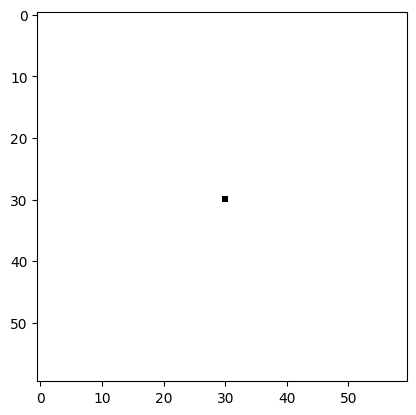

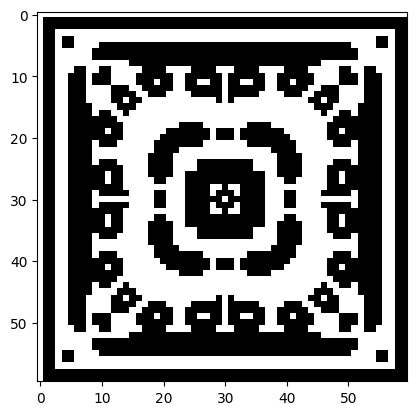

In [3]:
# initialize a 60x60 2D cellular automaton
cellular_automaton = cpl.init_simple2d(wspan, hspan)

cpl.plot2d(cellular_automaton)

# evolve the cellular automaton for 30 time steps,
#  applying totalistic rule 126 to each cell with a Moore neighbourhood
cellular_automaton = cpl.evolve2d(cellular_automaton, timesteps=train_size, neighbourhood='Moore',
                                  apply_rule=lambda n, c, t: cpl.totalistic_rule(n, k=num_classes, rule=126),
                                  memoize=True
                                 )

cpl.plot2d(cellular_automaton)

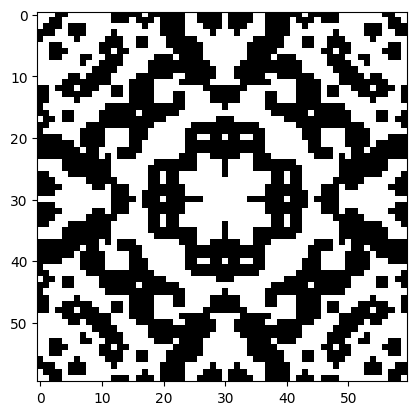

In [120]:
cellular_automaton = cpl.evolve2d(cellular_automaton, timesteps=90, neighbourhood='Moore',
                                  apply_rule=lambda n, c, t: cpl.totalistic_rule(n, k=2, rule=126),
                                 memoize=True)

cpl.plot2d(cellular_automaton)

(119, 60, 60) <class 'numpy.ndarray'>


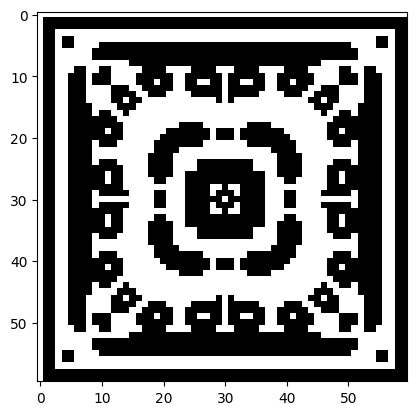

In [121]:
# from IPython.display import HTML
%matplotlib inline

ca = cellular_automaton.copy()
print(ca.shape, type(ca))
cpl.plot2d(ca[29:30, ...])

In [4]:
## Now we start playing with getting different datasets (besides just the game of life)

def generate_totalistic_data(config, random_rule=None, random_init=True):

    hspan, wspan = config['hspan'], config['wspan']
    k = config['num_classes']
    train_size = config['train_size']

    if random_rule is None:
        random_rule = np.random.randint(1000) # get some random number
    
    # First create the initial grid
    if random_init:
        initial_ca_state = cpl.init_random2d(rows=hspan, cols=wspan, k=k)
    else:  # Else initialize with single seed in the center
        initial_ca_state = cpl.init_simple2d(rows=hspan, cols=wspan)

    # If random rule is the Game of Life
    if random_rule == 'gol':
        cellular_automaton = cpl.evolve2d(initial_ca_state, timesteps=train_size, 
                     apply_rule=cpl.game_of_life_rule, memoize='recursive')
    else:    
        cellular_automaton = cpl.evolve2d(initial_ca_state, timesteps=train_size, memoize=True,
                                          apply_rule=lambda n,c,t: cpl.totalistic_rule(n, k=k, rule=random_rule))
    
    # Calculate some statistics about this cellular automaton
    entropy = cpl.average_cell_entropy(cellular_automaton)
    avg_mutual_information = cpl.average_mutual_information(cellular_automaton)

    # Generate the X and Y training sets
    X_train = cellular_automaton[:-1]
    Y_train = cellular_automaton[1:]

    # cpl.plot2d(initial_ca_state)
    # cpl.plot2d(cellular_automaton)
    print(f"Shannon entropy: {entropy}")
    print(f"The average mutual information is: {avg_mutual_information}")
    print(f"Random totalistic rule: {random_rule}")

    # Add information to config dictionary
    config['entropy'] = entropy
    config['avg_mutual_information'] = avg_mutual_information
    
    return X_train.astype(np.float32), Y_train.astype(np.float32), config


Shannon entropy: 1.528444094513062
The average mutual information is: 1.0641744489652214
Random totalistic rule: 126
Last state of the CA looks like this:


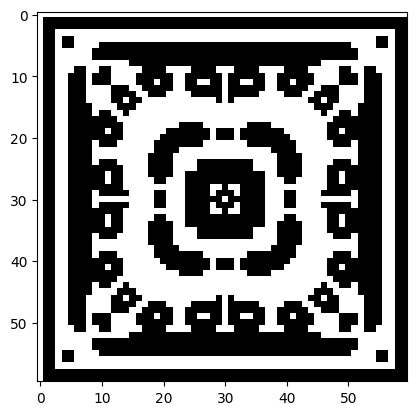

In [5]:
X_train, Y_train, config = generate_totalistic_data(config, random_rule=126, random_init=False)
print("Last state of the CA looks like this:")
cpl.plot2d(Y_train)

In [6]:
X_train.dtype, Y_train.dtype, config

(dtype('float32'),
 dtype('float32'),
 {'train_size': 30,
  'wspan': 60,
  'hspan': 60,
  'num_classes': 2,
  'layer_dims': [10, 10, 10],
  'learning_rate': 0.01,
  'entropy': 1.528444094513062,
  'avg_mutual_information': 1.0641744489652214})

In [7]:
trainer = Trainer(network_fn, config, X_train, Y_train)

In [8]:
state, loss, batch = trainer.train(epochs=701)

Initializing model


  0%|                                                   | 0/701 [00:00<?, ?it/s]

loss at epoch 0: 0.69088250


  4%|█▊                                        | 30/701 [00:03<01:01, 10.85it/s]

loss at epoch 50: 0.55613911


 12%|█████▏                                    | 86/701 [00:04<00:17, 36.07it/s]

loss at epoch 100: 0.54739827


 20%|████████▏                                | 141/701 [00:04<00:08, 63.33it/s]

loss at epoch 150: 0.54405928


 28%|███████████▌                             | 198/701 [00:05<00:05, 89.36it/s]

loss at epoch 200: 0.54347044


 31%|████████████▊                            | 220/701 [00:05<00:06, 76.17it/s]

loss at epoch 250: 0.54326981


 41%|████████████████▍                       | 288/701 [00:06<00:03, 103.55it/s]

loss at epoch 300: 0.54373354


 49%|████████████████████▏                    | 345/701 [00:07<00:04, 82.68it/s]

loss at epoch 350: 0.54423267


 52%|█████████████████████▍                   | 367/701 [00:07<00:04, 73.15it/s]

loss at epoch 400: 0.54488069


 62%|█████████████████████████▌               | 437/701 [00:08<00:02, 98.67it/s]

loss at epoch 450: 0.54296023


 70%|████████████████████████████▉            | 494/701 [00:09<00:02, 93.52it/s]

loss at epoch 500: 0.54294205


 78%|███████████████████████████████▏        | 547/701 [00:09<00:01, 103.45it/s]

loss at epoch 550: 0.54159248


 81%|█████████████████████████████████▏       | 568/701 [00:10<00:01, 80.56it/s]

loss at epoch 600: 0.54369146


 91%|████████████████████████████████████▎   | 637/701 [00:10<00:00, 107.80it/s]

loss at epoch 650: 0.54310197


 99%|███████████████████████████████████████▍| 691/701 [00:11<00:00, 113.89it/s]

loss at epoch 700: 0.54309118


100%|█████████████████████████████████████████| 701/701 [00:11<00:00, 60.22it/s]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,700
loss,0.54309


In [9]:
losses, preds = trainer.evaluate(state, batch)
preds.shape, losses.shape

(29, 3600, 2)


((29, 60, 60), (29,))

In [ ]:
def sample_output(i=None):
    if i is None:
        i = np.random.randint(config['train_size'])
    
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
    ax0.imshow(batch.input_states[i], cmap='gray')
    ax1.imshow(preds[i], cmap='gray')
    ax2.imshow(batch.output_states[i], cmap='gray')

    print(f"Showing output for sample index {i}")
    ax0.set_title("Input state")
    ax1.set_title(f"Network prediction\n Loss: {losses[i]:.3f}")
    ax2.set_title("Expected output")

    # print(np.allclose(preds[i], batch.output_states[i], 1))
    
    fig.show()

sample_output()

Showing output for sample index 8


In [53]:
state.params.keys()

dict_keys(['conv2_d', 'linear', 'linear_1', 'linear_2'])

In [101]:
state.params['linear']

{'b': Array([ 0.8592717 ,  0.6382573 , -0.13122565,  0.17485434, -0.9509522 ,
         0.21001194, -0.61899704, -0.18549381,  0.6602366 , -0.41422307],      dtype=float32),
 'w': Array([[ 1.588022  , -0.99783015, -0.9424473 , -0.87889904,  0.9701816 ,
          0.521644  ,  0.6596344 , -0.14601475, -1.0883386 , -0.24025197],
        [ 0.5977404 ,  0.30187994,  0.7747946 , -1.2254877 , -0.1662703 ,
          0.6547842 , -0.5956883 ,  0.01980493,  0.5308538 , -1.3611084 ],
        [ 1.5526215 ,  0.07584317, -0.24706799, -0.6626715 ,  1.4958545 ,
         -0.72013307,  1.120972  , -0.5954493 ,  0.04138995, -0.4736578 ],
        [ 1.4602559 , -0.860617  , -0.957707  , -1.2094061 ,  1.3887771 ,
          1.0615445 ,  1.1235297 , -0.08197156, -0.7650332 , -1.0844675 ],
        [ 1.5115712 , -0.87748253, -0.36987558, -1.4840214 , -0.17466727,
          0.7140048 , -0.12885873,  0.16476874, -0.01122659, -1.0194228 ],
        [ 1.2555254 , -1.0970948 , -0.6394633 , -0.01263659, -0.1532264 ,
   

In [100]:
for key in state.params.keys():
    print(state.params[key])
    # plt.hist(state.params[key])

{'b': Array([ 0.69263196,  0.6346218 ,  0.03469291,  0.1834173 , -0.318854  ,
       -0.25989184, -0.02503752, -1.033849  ,  0.5168198 ,  0.74983156],      dtype=float32), 'w': Array([[[[-0.71454304,  0.53485596, -0.5316769 , -0.34163642,
          -0.2956887 , -0.36212316, -0.91466784, -0.39700082,
          -0.21131143, -0.39190906]],

        [[-0.53842896,  0.46261877, -0.28206652, -0.5648309 ,
           0.10924945,  0.08504424,  0.14062199,  0.1807003 ,
          -0.537885  , -0.34444347]],

        [[-0.5496939 , -0.6978107 , -0.48181102, -0.5702212 ,
           0.08617242, -0.34800434, -0.5085652 ,  0.47759596,
          -0.15162039,  1.4330441 ]]],


       [[[-0.5282686 ,  0.11953981,  0.73692244,  0.40565094,
          -0.18004337,  1.014837  , -0.17754923,  0.68211824,
          -0.8754142 , -0.37368834]],

        [[-0.5030161 , -0.4778917 , -0.3372099 ,  0.35878325,
          -0.1522907 , -0.517628  ,  0.38084644,  0.61873716,
          -0.4002397 , -0.35065976]],

      